In [1]:
import torch
import pandas as pd
import torch.nn as nn
from pandas import DataFrame


In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

mean, std = dict(), dict()

def normalize(df, train):
    for col in df:
        if df[col].dtype == object:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            
        df[col] = df[col].astype(float)        
        
        if train:
            mean[col] = df[col].mean()
            std[col] = df[col].std()
        
        df[col].fillna(mean[col], inplace=True)        
        df[col] = (df[col] - mean[col]) / std[col]    
        

In [3]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col=0)

In [4]:
normalize(train_df, True)
train_df.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,...,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,-9.976799e-17,-2.822704e-16,-2.287364e-16,-7.056760e-17,6.083414e-16,-1.107181e-16,1.338351e-16,-1.192349e-16,-4.866731e-18,9.003452e-17,...,4.866731e-18,7.275763e-16,7.056760e-17,-1.569521e-16,-4.866731e-18,9.733462e-17,3.562265e-14,1.764190e-16,1.958859e-16,1.314017e-16
std,1.000000e+00,1.000000e+00,9.069075e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.722639e-01,-4.792221e+00,-2.019784e+00,-9.234128e-01,-1.556173e+01,-4.821525e+00,-1.378460e+00,-3.924730e+00,-2.617120e-02,-1.860664e+00,...,-6.866822e-02,-2.125825e+01,-3.236454e+00,-9.706927e+00,-8.765778e-02,-1.968437e+00,-1.367186e+00,-4.840547e+00,-3.425110e+00,-1.838074e+00
25%,-8.722639e-01,-4.551634e-02,-4.138382e-01,-2.968890e-01,6.421621e-02,2.446330e-01,-1.378460e+00,3.145591e-01,-2.617120e-02,-6.281009e-01,...,-6.866822e-02,6.328308e-02,4.572907e-01,1.915283e-01,-8.765778e-02,-4.889425e-01,-6.142282e-01,3.137596e-01,2.084309e-01,-6.412965e-01
50%,-1.630536e-01,-4.551634e-02,0.000000e+00,-1.040277e-01,6.421621e-02,2.446330e-01,7.504734e-01,3.145591e-01,-2.617120e-02,6.044627e-01,...,-6.866822e-02,6.328308e-02,4.572907e-01,1.915283e-01,-8.765778e-02,-1.190689e-01,1.387300e-01,3.137596e-01,2.084309e-01,-2.255870e-01
75%,3.097533e-01,-4.551634e-02,3.685457e-01,1.086708e-01,6.421621e-02,2.446330e-01,7.504734e-01,3.145591e-01,-2.617120e-02,6.044627e-01,...,-6.866822e-02,6.328308e-02,4.572907e-01,1.915283e-01,-8.765778e-02,6.206783e-01,8.916881e-01,3.137596e-01,2.084309e-01,4.163867e-01
max,3.146594e+00,1.536718e+00,1.000422e+01,2.051125e+01,6.421621e-02,2.446330e-01,7.504734e-01,3.145591e-01,3.818378e+01,6.044627e-01,...,1.829991e+01,6.328308e-02,4.572907e-01,1.915283e-01,3.115459e+01,2.100173e+00,1.644646e+00,3.137596e-01,1.116816e+00,7.226343e+00


In [5]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df):
        self.data = df.values
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = torch.tensor(self.data[index, :-1])
        y = torch.tensor(self.data[index, -1:])
        return x, y

In [6]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout1, dropout2):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(hidden_size1, dtype=float),
            nn.ReLU(),                                                
        )
        
        self.dropout1 = nn.Dropout(dropout1)
        
        self.fc2 = nn.Sequential(
            nn.LazyLinear(hidden_size2, dtype=float),
            nn.ReLU()
        )
        
        self.dropout2 = nn.Dropout(dropout2)
        
        self.fc3 = nn.LazyLinear(output_size, dtype=float)                    
        
        
    def forward(self, x):                
        y = self.fc1(x)
        if self.train:
            y = self.dropout1(y)
        y = self.fc2(y)
        if self.train:
            y = self.dropout2(y)
        return self.fc3(y)

In [7]:
hparams = {
    'input_size': train_df.shape[1],
    'output_size': 1,
    'hidden_size1': 256,
    'hidden_size2': 128,
    'dropout1': 0.5,
    'dropout2': 0.125    
}

In [8]:
criterion = nn.MSELoss(reduction='sum')
def log_rmse_loss(predicted, target):    
    log_predicted = torch.log(predicted)        
    log_target = torch.log(target)
    mse_loss = torch.mean((log_predicted - log_target)**2)
    rmse_loss = torch.sqrt(mse_loss)
    return rmse_loss


def get_losses(df, model):
    x_tensor, y_tensor = torch.tensor(df.values[:, :-1]), torch.tensor(df.values[:, -1:])    
    y_pred = model(x_tensor)
    
    predicted = (y_pred * std['SalePrice'] + mean['SalePrice']).clamp(min=1)
    target = y_tensor * std['SalePrice'] + mean['SalePrice']    
    return log_rmse_loss(predicted, target).item(), criterion(predicted, target).item()

In [9]:
def train(df, epoch_count, lr, wd):
    model = Net(**hparams)
    model.train()
        
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    
    dataset = CustomDataset(df)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    for epoch in range(epoch_count):
        loss_sum = 0.0

        for batch in dataloader:
            x_tensor, y_tensor = batch
            y_pred = model(x_tensor)
            loss = criterion(y_pred, y_tensor)                            
            loss_sum += loss.item()

            assert not torch.isnan(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def k_fold(df, epoch_count, lr, wd, k = 5):
    fold_indices = np.array_split(np.arange(len(df)), k)    
    test_log_rmses = []
    train_log_rmses = []
    test_mses = []
    train_mses = []
    
    for fold in range(k):                        
        test_indices = fold_indices[fold]
        train_indices = np.concatenate(fold_indices[:fold] + fold_indices[fold+1:])
                                            
        model = train(df.iloc[train_indices], epoch_count, lr, wd)
        
        test_log_rmse, test_mse = get_losses(df.iloc[test_indices], model)
        test_log_rmses.append(test_log_rmse)
        test_mses.append(test_mse)
    
        train_log_rmse, train_mse = get_losses(df.iloc[train_indices], model)                                        
        train_log_rmses.append(train_log_rmse)
        train_mses.append(train_mse)                
        
    return sum(test_log_rmses) / len(test_log_rmses), sum(train_log_rmses) / len(train_log_rmses)
    

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


1 0.15693550191627645 0.11755203575740385
2 0.14743233563544586 0.1645002158770962
3 0.15090978843142938 0.13478289238260435
4 0.15419404884347904 0.1396936373067958
5 0.15391697364436502 0.14267190497502638


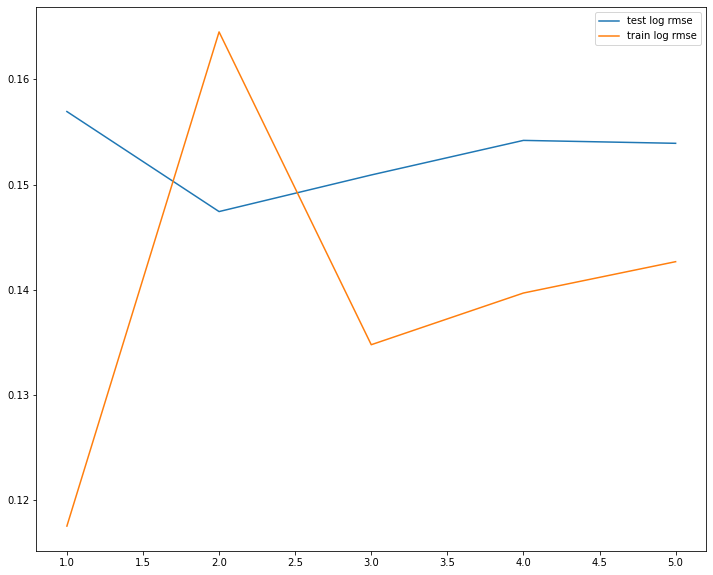

In [11]:
lr = 1.5e-3
wd = 3
ec = 200
to_show = True

if to_show:
    candidates = [1, 2, 3, 4, 5]
    test_log_rmses = []
    train_log_rmses = []
    for can in candidates:
        test_log_rmse, train_log_rmse = k_fold(train_df, epoch_count = ec, lr=lr, wd=can)
        test_log_rmses.append(test_log_rmse)
        train_log_rmses.append(train_log_rmse)
        print(can, test_log_rmse, train_log_rmse)

    plt.figure(figsize=(12, 10))    
    plt.plot(candidates, test_log_rmses, label='test log rmse')
    plt.plot(candidates, train_log_rmses, label='train log rmse')
    plt.legend(loc='best')
    plt.show()    

In [12]:
model = train(train_df, ec, lr=lr, wd=wd)
model.eval()

Net(
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=79, out_features=256, bias=True)
    (2): ReLU()
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (dropout2): Dropout(p=0.125, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col=0)

In [14]:
normalize(test_df, True)
test_df.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,...,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03
mean,6.087583e-17,2.398508e-16,1.461020e-16,1.363619e-16,-2.593311e-16,7.792107e-17,-1.144466e-16,5.844080e-17,-2.435033e-18,-9.374878e-17,...,4.139557e-17,2.922040e-17,-6.440663e-16,2.435033e-18,-9.009623e-16,1.582772e-17,5.844080e-17,-7.846652e-14,-2.045428e-16,-7.305100e-17
std,1.000000e+00,1.000000e+00,9.188619e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.744110e-01,-4.384003e+00,-2.126321e+00,-1.684821e+00,-1.555637e+01,-4.172861e+00,-1.384162e+00,-3.958933e+00,-3.703705e-02,-1.950142e+00,...,-3.014397e-01,-5.720732e-02,-2.543645e+01,-3.165818e+00,-1.274547e+01,-9.221192e-02,-1.874861e+00,-1.359492e+00,-4.570157e+00,-3.588588e+00
25%,-8.744110e-01,-4.657508e-02,-3.834481e-01,-4.899914e-01,6.423828e-02,2.694624e-01,-1.384162e+00,3.185910e-01,-3.703705e-02,-6.889464e-01,...,-3.014397e-01,-5.720732e-02,4.366023e-02,4.704177e-01,1.741507e-01,-9.221192e-02,-7.729049e-01,-5.912895e-01,3.241335e-01,2.013142e-01
50%,-1.726054e-01,-4.657508e-02,0.000000e+00,-8.478652e-02,6.423828e-02,2.694624e-01,7.423656e-01,3.185910e-01,-3.703705e-02,5.722491e-01,...,-3.014397e-01,-5.720732e-02,4.366023e-02,4.704177e-01,1.741507e-01,-9.221192e-02,-3.826760e-02,1.769130e-01,3.241335e-01,2.013142e-01
75%,2.952650e-01,-4.657508e-02,4.209550e-01,3.427168e-01,6.423828e-02,2.694624e-01,7.423656e-01,3.185910e-01,-3.703705e-02,5.722491e-01,...,-3.014397e-01,-5.720732e-02,4.366023e-02,4.704177e-01,1.741507e-01,-9.221192e-02,6.963697e-01,9.451154e-01,3.241335e-01,2.013142e-01
max,3.102487e+00,2.845044e+00,5.873020e+00,9.440152e+00,6.423828e-02,2.694624e-01,7.423656e-01,3.185910e-01,2.698149e+01,5.722491e-01,...,9.873484e+00,2.617949e+01,4.366023e-02,4.704177e-01,1.741507e-01,2.685739e+01,2.165644e+00,1.713318e+00,9.359199e-01,1.148790e+00


In [15]:
x_tensor = torch.tensor(test_df.iloc[:, :].values, dtype=float)
x_tensor.shape

torch.Size([1459, 79])

In [16]:
y_tensor = model(x_tensor)
y_tensor.shape

torch.Size([1459, 1])

In [17]:
with torch.no_grad():
    outputs = model(x_tensor)    
    result = pd.DataFrame({'Id': test_df.index, 'SalePrice': outputs.reshape(outputs.shape[0])})
    result['SalePrice'] = result['SalePrice'] * std['SalePrice'] + mean['SalePrice']
    result.to_csv('sub.csv', index=False)
    